# FineST in NPC Visium data

## Main steps

- Step1: Align image patch and ST spot: using image pixels with spot coordinates
- Step2: Train model on within-spots: train model on 80% - test on 20% of the data
- Step3: Infer gene expression of between-spots using the trained model
- Step4: Impute (smooth) on all sub-spots using measured spot expression

In [1]:
import os
import time
import torch
import numpy as np
import pandas as pd
import scanpy as sc
from datetime import datetime
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.INFO)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
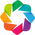

FineST version: 0.1.2
CUDA is available. GPU: NVIDIA GeForce RTX 3090


In [ ]:
## From local
# path = '/home/lingyu/ssd/Python/'
# os.chdir(str(path) + 'FineSTtest09/FineST/')
# import FineST as fst
# from FineST.datasets import dataset
# import FineST.plottings as fstplt
# print("FineST version: %s" %fst.__version__)

## install FineST package
import FineST as fst
from FineST.datasets import dataset
import FineST.plottings as fstplt
print("torch version: %s" %torch.__version__)
print("FineST version: %s" %fst.__version__)

fst.setup_seed(666)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
## Set path
path = '/home/lingyu/ssd/Python/'
os.chdir(f'{path}FineSTtest09/FineST/')
# os.chdir(f'{path}FineST/FineST_demo/')    # here I use FineST_demo

## Set logging
model_folder = 'logging/'
dir_name = model_folder + datetime.now().strftime('%Y%m%d%H%M%S%f')
print('dir_name: ', dir_name)
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    logger = fst.setup_logger(dir_name)

## Set parameter 
parameter_file_path = 'parameter/parameters_NPC_HIPT.json'
with open(parameter_file_path,"r") as json_file:
    params = json.load(json_file)
logger.info("Load parameters:\n" + json.dumps(params, indent=2))

[2025-09-25 13:41:53] INFO - Load parameters:
{
  "n_encoder_hidden_matrix": 256,
  "n_encoder_hidden_image": 128,
  "n_encoder_latent": 128,
  "n_projection_hidden": 256,
  "n_projection_output": 128,
  "batch_size": 200,
  "batch_size_pair": 64,
  "n_encoder_layers": 2,
  "dropout_rate": 0,
  "training_epoch": 50,
  "inital_learning_rate": 0.1,
  "k_nearest_positives": 0,
  "temperature": 0.03,
  "n_input_image": 384,
  "w1": 0,
  "w2": 0,
  "w3": 1,
  "w4": 1
}


dir_name:  logging/20250925134153645161


You can set `parameter_file_path` as the optimal parameters obtained from your train and test model for your dataset, but here we use our trained parameter for paper results repeated (saved in `parameter/parameters_NPC_HIPT.json`).

## 1. Load ST RNA-seq and Image data

In [8]:
## Download the FineST_tutorial_data folder 
!python -m pip install gdown
!gdown --folder https://drive.google.com/drive/folders/1rZ235pexAMVvRzbVZt1ONOu7Dcuqz5BD?usp=drive_link

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gdown]
Retrieving folder contents
Retrieving folder 1ZhmOHGmdjaIuphq0dpy-nhX0aYoNlyHV spatial
Processing file 1PknZgvSkfc_Jqu0m7SZZqPLEBkRXBgVP aligned_fiducials.jpg
Processing file 1W1DFzhpyCSqv0Kz7sBY5xg0-GqKZwqwR detected_tissue_image.jpg
Processing file 1YxcGZPNXPvma_ne4MjatxBWsB0ML4WrC scalefactors_json.json
Processing file 1h-MtLzKy2fkrg9Gi2c_Yg_WWHxThDYjC tissue_hires_image.png
Processing file 12J0gbG5ZoQ1lQAuNc5-K9M0f1WVP5OwJ tissue_lowres_image.png
Processing file 1MCg-X3lSW0e1Ayxfrf6ZNje-EUOsysDV tissue_positions_list.csv
Processing file 1e8ujFARX2dJAIA4sTS56OWF1KIVtvmlv 20210809-C-AH4199551.tif
Processing file 1TtKlbthxfuO6XVJpkYZAwq0tTBSB_IiA filtered_feature_bc_matrix.h5
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1PknZgvSkfc_Jqu0m7SZZqPLEBkRXBgVP
To: /ssd/users/lingyu/Python/FineSTtest09/FineST/FineST_tutorial_da

A human Nasopharyngeal carcinoma dataset (NPC_patient_1) from [Gong, et al](https://www.nature.com/articles/s41467-023-37614-6). will be used as a reference dataset, raw_feature_bc_matrix, filtered_feature_bc_matrix, and spatial coordinates (.h5) are publicly available in [GSE200310](https://ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE200310). For easier reuse, we included them in an anndata object which can be loaded directly in FineST Python package. Otherwise you can also using: \
`demo_data = 'FineST_tutorial_data/' ` \
`adata = sc.read_visium(f'{demo_data}')`

In [4]:
adata = dataset.NPC()
print(adata)

AnnData object with n_obs × n_vars = 1331 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In FineST, we only considers 963 human genes involved in ligand-receptor pairs from [CellChatDB (version.1.1.3)](https://github.com/sqjin/CellChat/tree/master/data) (mouse: 2,022 pairs, human: 1,940 pairs, zebrafish: 2,774 pairs), and extract the overlap gene's expression profile.

In [5]:
## Selected LR genes. Here gene_list can be 'LR_genes', 'HV_genes' or 'LR_HV_genes'
adata = fst.adata_LR(adata, gene_list='LR_genes')

After making an intersection with the LR genes and filtering out genes that are detected in less than 10 cells, 596 genes from the NPC datasetare used for training and prediction.

In [6]:
adata_count = adata.copy()
adata = fst.adata_preprocess(adata_count, normalize=False)

<div class="alert alert-info">

**Note**
The spatial coordinates `tissue_positions_list.csv` and gene expression matrix `row/barcode` need to be re-ordered by the segmented image file name.
</div>

**Step0: HE image feature extraction**
```python
python ./demo/Image_feature_extraction.py \
   --dataset NPC \
   --position_path FineST_tutorial_data/spatial/tissue_positions_list.csv  \
   --rawimage_path FineST_tutorial_data/20210809-C-AH4199551.tif \
   --scale_image False \
   --method virchow2 \
   --patch_size 112 \
   --output_img FineST_tutorial_data/ImgEmbeddings/pth_112_14_image \
   --output_pth FineST_tutorial_data/ImgEmbeddings/pth_112_14 \
   --logging FineST_tutorial_data/ImgEmbeddings/
```

When using `virchow2`, if you met 'Request Status' after registering in `huggingface`, which usually takes several days to get the token. In this case, it is recommended to use 'HIPT' first, as it does not require a token and can be used immediately.

**Step0: HE image feature extraction**
```python
python ./demo/Image_feature_extraction.py \
   --dataset NPC \
   --position_path FineST_tutorial_data/spatial/tissue_positions_list.csv  \
   --rawimage_path FineST_tutorial_data/20210809-C-AH4199551.tif \
   --scale_image False \
   --method HIPT \
   --patch_size 64 \
   --output_img FineST_tutorial_data/ImgEmbeddings/pth_64_16_image \
   --output_pth FineST_tutorial_data/ImgEmbeddings/pth_64_16 \
   --logging FineST_tutorial_data/ImgEmbeddings/
```

In [7]:
!python ./demo/Image_feature_extraction.py \
   --dataset NPC \
   --position_path FineST_tutorial_data/spatial/tissue_positions_list.csv  \
   --rawimage_path FineST_tutorial_data/20210809-C-AH4199551.tif \
   --scale_image False \
   --method HIPT \
   --patch_size 64 \
   --output_img FineST_tutorial_data/ImgEmbeddings/pth_64_16_image \
   --output_pth FineST_tutorial_data/ImgEmbeddings/pth_64_16 \
   --logging FineST_tutorial_data/ImgEmbeddings/

      ACGCCTGACACGCGCT-1  0  0.1  0.2   1416   1884
0     TACCGATCCAACACTT-1  0    1    1   1603   1991
1     ATTAAAGCGGACGAGC-1  0    0    2   1417   2098
2     GATAAGGGACGATTAG-1  0    1    3   1604   2205
3     GTGCAAATCACCAATA-1  0    0    4   1417   2313
4     TGTTGGCTGGCGGAAG-1  0    1    5   1604   2420
...                  ... ..  ...  ...    ...    ...
4986  GAACGTTTGTATCCAC-1  0   77  123  15822  15041
4987  ATTGAATTCCCTGTAG-1  0   76  124  15635  15148
4988  TACCTCACCAATTGTA-1  0   77  125  15822  15255
4989  AGTCGAATTAGCGTAA-1  0   76  126  15636  15363
4990  TTGAAGTGCATCTACA-1  0   77  127  15823  15470

[4991 rows x 6 columns]
[2025-09-25 13:42:15] INFO - tissue_position: 
                     in_tissue  ...  pxl_row_in_fullres
0                              ...                    
GTGTGAGCCGAGGTGC-1          1  ...                5423
GGGAACCACCTGTTTC-1          1  ...                5638
GTTCGTTGCGGACCAG-1          1  ...                5745
TGAGGTTGATCCCAAG-1          

The image embedding file `ImgEmbeddings` can be downloaded from [Goole Drive](https://drive.google.com/drive/folders/1w6hbMd0eUPJ4tFUft0O796NEbOrCeBxp?usp=sharing) 
- within spots: `pth_64_16`, between spots: `NEW_pth_64_16`, single-nuclei: `sc_pth_16_16`).

In [ ]:
## Load ST spot position
demo_data = 'FineST_tutorial_data/'
position = pd.read_csv(f'{demo_data}spatial/tissue_positions_list.csv', header=None)
position = position.rename(columns={position.columns[-2]: 'pixel_x', 
                                    position.columns[-1]: 'pixel_y'})
print("The coords of ST spot: ", position.shape)

## Order spot position by image file name
file_paths = sorted(os.listdir(f'{demo_data}/ImgEmbeddings/pth_64_16/'))
print("Image embedding file: ", file_paths[:3])

## Get patch position and merge position
# Note: ST_class='Visium' is used for image coordinate parsing (works for both Visium16 and Visium64)
position_image = fst.get_image_coord(file_paths, ST_class="Visium")
position_image = fst.image_coord_merge(position_image, position, ST_class = 'Visium')
position_order = fst.update_st_coord(position_image)
print("The coords of image patch (merged): ", position_order.shape)
print(position_order.head())

## Save the position data  -- train model used
link_data = 'OrderData/'
save_dir = os.path.join(demo_data, link_data)
os.makedirs(save_dir, exist_ok=True)  
position_order.to_csv(f'{demo_data}{link_data}position_order.csv', index=False, header=False)

## Order matrix row/barcode, spatial coordinates by image coordinates
spotID_order = np.array(position_image[0])
gene_hv = np.array(adata.var_names)
matrix_order, matrix_order_df = fst.sort_matrix(adata, position_image, spotID_order, gene_hv)

## Save gene expression mateix -- train model used
np.save(f'{demo_data}{link_data}matrix_order.npy', matrix_order_df.T)

The coords of ST spot:  (4992, 6)
Image embedding file:  ['NPC_10014_10023.pth', 'NPC_10015_9649.pth', 'NPC_10016_9276.pth']
The coords of image patch (merged):  (1331, 4)
   pixel_y  pixel_x  array_row  array_col
0    10014    10023         76         46
1    10015     9649         76         44
2    10016     9276         76         42
3    10020     7783         76         34
4    10021     7410         76         32


(1331, 596)


In [9]:
## Update adata with new barcodes and lications
adata = fst.update_adata_coord(adata, matrix_order_df, position_image)
print(adata)
adata_count = adata.copy()
adata_norml = fst.adata_preprocess(adata.copy(), normalize=True)

## Save adata
save_data = 'SaveData/'
save_dir = os.path.join(demo_data, save_data)
os.makedirs(save_dir, exist_ok=True)  
adata_count.write_h5ad(f'{demo_data}{save_data}adata_count.h5ad')
adata_norml.write_h5ad(f'{demo_data}{save_data}adata_norml.h5ad')

AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


<div class="alert alert-info">

**Note**
The above two cells only need to be run once. They aim to generate the ordered gene expression profile `matrix_order.npy` and the ordered ST spot coordinates `position_order.csv` according to image pixel coordinates, and save the original and normalized gene expression data `adata_count.h5ad`,`adata_norml.h5ad`. 

</div>

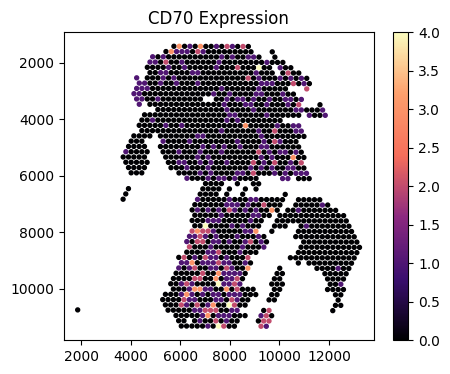

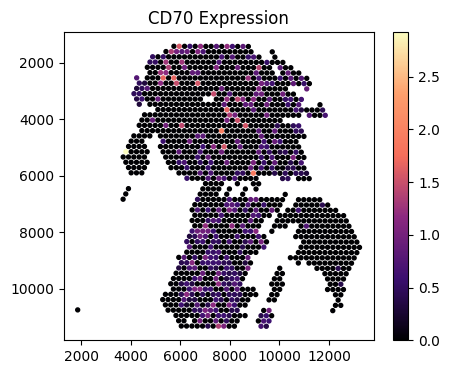

In [10]:
fig_path = 'Figures/'
save_dir = os.path.join(demo_data, fig_path)
os.makedirs(save_dir, exist_ok=True)  

fstplt.gene_expr(adata_count, adata_count.to_df(), gene_selet='CD70', marker='o', 
                 s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD70_expr_count.pdf')
fstplt.gene_expr(adata_norml, adata_norml.to_df(), gene_selet='CD70', marker='o', 
                 s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD70_expr_norml.pdf')

## 2. Train model and Internal validation

**Input: three input file**

- `image_embed_path`: image embedding from **Setp0** `Image_feature_extraction.py` \
- `spatial_pos_path`: ordered ST spot coords, in `f'{demo_data}{link_data}position_order.csv` \
- `reduced_mtx_path`: ordered gene expression, in `f'{demo_data}{link_data}matrix_order.npy` 

The `OrderData` can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1b3Ai14lLdsTR07BXLFJu3vFuB3C54WxJ?usp=sharing).

In [11]:
image_embed_path = f'{demo_data}ImgEmbeddings/pth_64_16/*.pth' 
spatial_pos_path = f'{demo_data}{link_data}position_order.csv'
reduced_mtx_path = f'{demo_data}{link_data}/matrix_order.npy'

2.1 Train and test model on within spot, with plitting: 80% for train and 20% for test

In [12]:
## add params
params['n_input_matrix'] = len(gene_hv)

## init the model
model = fst.FineSTModel(n_input_matrix=params['n_input_matrix'],
                              n_input_image=params['n_input_image'],
                              n_encoder_hidden_matrix=params["n_encoder_hidden_matrix"],
                              n_encoder_hidden_image=params["n_encoder_hidden_image"],
                              n_encoder_latent=params["n_encoder_latent"],
                              n_projection_hidden=params["n_projection_hidden"],
                              n_projection_output=params["n_projection_output"],
                              n_encoder_layers=params["n_encoder_layers"]).to(device) 
## Load the data
train_loader, test_loader = fst.build_loaders(batch_size=params['batch_size'], 
                                              image_embed_path=image_embed_path, 
                                              spatial_pos_path=spatial_pos_path, 
                                              reduced_mtx_path=reduced_mtx_path, 
                                              image_clacss='HIPT',
                                              dataset_class='Visium16') 
## Set optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=params['inital_learning_rate'], 
                            momentum=0.9, weight_decay=5e-4)
## Load loss function
l = fst.ContrastiveLoss(temperature=params['temperature'], 
                        w1=params['w1'], w2=params['w2'], w3=params['w3'], w4=params['w4'])

## train model
(dir_name, 
 train_losses, test_losses, 
 best_epoch, best_loss) = fst.train_model_fst(params, model, train_loader, test_loader, 
                                          optimizer, l, dir_name, logger, dataset_class='Visium16')

CUDA is available. GPU: NVIDIA GeForce RTX 3090
Finished loading all files
train/test split completed
1064 267
***** Finished building loaders *****


[2025-09-25 13:42:30] INFO - Begin Training ...
[2025-09-25 13:42:30] INFO - epoch [1/50]


Epoch: 1
train model


100%|██████████| 5/5 [00:00<00:00, 97.57it/s]


--- 0.9125933647155762 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 55.97it/s]
[2025-09-25 13:42:31] INFO - Best epoch_loss: [0: 1.5930]
[2025-09-25 13:42:31] INFO - epoch [2/50]


Epoch: 2
train model


100%|██████████| 5/5 [00:00<00:00, 109.73it/s]


--- 0.4810171127319336 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 30.92it/s]
[2025-09-25 13:42:32] INFO - Best epoch_loss: [1: 1.5421]
[2025-09-25 13:42:32] INFO - epoch [3/50]


Epoch: 3
train model


100%|██████████| 5/5 [00:00<00:00, 103.71it/s]


--- 0.6437828540802002 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 93.18it/s]
[2025-09-25 13:42:33] INFO - Best epoch_loss: [2: 1.5059]
[2025-09-25 13:42:33] INFO - epoch [4/50]


Epoch: 4
train model


100%|██████████| 5/5 [00:00<00:00, 88.75it/s]


--- 0.6227970123291016 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 31.41it/s]
[2025-09-25 13:42:33] INFO - Best epoch_loss: [3: 1.4970]
[2025-09-25 13:42:33] INFO - epoch [5/50]


Epoch: 5
train model


100%|██████████| 5/5 [00:00<00:00, 104.79it/s]


--- 0.640160322189331 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 48.69it/s]
[2025-09-25 13:42:34] INFO - Best epoch_loss: [4: 1.4903]
[2025-09-25 13:42:34] INFO - epoch [6/50]


Epoch: 6
train model


100%|██████████| 5/5 [00:00<00:00, 95.21it/s]


--- 0.6764194965362549 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 49.73it/s]
[2025-09-25 13:42:35] INFO - Best epoch_loss: [5: 1.4834]
[2025-09-25 13:42:35] INFO - epoch [7/50]


Epoch: 7
train model


100%|██████████| 5/5 [00:00<00:00, 110.21it/s]


--- 0.64522385597229 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 57.16it/s]
[2025-09-25 13:42:35] INFO - Best epoch_loss: [6: 1.4692]
[2025-09-25 13:42:35] INFO - epoch [8/50]


Epoch: 8
train model


100%|██████████| 5/5 [00:00<00:00, 112.47it/s]


--- 0.5827844142913818 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 46.92it/s]
[2025-09-25 13:42:36] INFO - Best epoch_loss: [7: 1.4657]
[2025-09-25 13:42:36] INFO - epoch [9/50]


Epoch: 9
train model


100%|██████████| 5/5 [00:00<00:00, 109.65it/s]


--- 0.494614839553833 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 55.61it/s]
[2025-09-25 13:42:37] INFO - Best epoch_loss: [8: 1.4548]
[2025-09-25 13:42:37] INFO - epoch [10/50]


Epoch: 10
train model


100%|██████████| 5/5 [00:00<00:00, 113.05it/s]


--- 0.6066837310791016 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 56.48it/s]
[2025-09-25 13:42:37] INFO - epoch [11/50]


Epoch: 11
train model


100%|██████████| 5/5 [00:00<00:00, 112.26it/s]


--- 0.6033027172088623 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]
[2025-09-25 13:42:38] INFO - Best epoch_loss: [10: 1.4514]
[2025-09-25 13:42:38] INFO - epoch [12/50]


Epoch: 12
train model


100%|██████████| 5/5 [00:00<00:00, 110.94it/s]


--- 0.6600985527038574 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 57.49it/s]
[2025-09-25 13:42:39] INFO - epoch [13/50]


Epoch: 13
train model


100%|██████████| 5/5 [00:00<00:00, 109.41it/s]


--- 0.6030969619750977 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 57.62it/s]
[2025-09-25 13:42:39] INFO - Best epoch_loss: [12: 1.4496]
[2025-09-25 13:42:39] INFO - epoch [14/50]


Epoch: 14
train model


100%|██████████| 5/5 [00:00<00:00, 112.87it/s]


--- 0.5560333728790283 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 57.76it/s]
[2025-09-25 13:42:40] INFO - Best epoch_loss: [13: 1.4474]
[2025-09-25 13:42:40] INFO - epoch [15/50]


Epoch: 15
train model


100%|██████████| 5/5 [00:00<00:00, 111.96it/s]


--- 0.6699738502502441 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 55.38it/s]
[2025-09-25 13:42:41] INFO - Best epoch_loss: [14: 1.4369]
[2025-09-25 13:42:41] INFO - epoch [16/50]


Epoch: 16
train model


100%|██████████| 5/5 [00:00<00:00, 96.56it/s]


--- 0.5456275939941406 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 98.63it/s]
[2025-09-25 13:42:41] INFO - Best epoch_loss: [15: 1.4319]
[2025-09-25 13:42:41] INFO - epoch [17/50]


Epoch: 17
train model


100%|██████████| 5/5 [00:00<00:00, 108.57it/s]


--- 0.5987081527709961 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 57.98it/s]
[2025-09-25 13:42:42] INFO - epoch [18/50]


Epoch: 18
train model


100%|██████████| 5/5 [00:00<00:00, 110.87it/s]


--- 0.5896263122558594 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 34.69it/s]
[2025-09-25 13:42:43] INFO - Best epoch_loss: [17: 1.4285]
[2025-09-25 13:42:43] INFO - epoch [19/50]


Epoch: 19
train model


100%|██████████| 5/5 [00:00<00:00, 110.61it/s]


--- 0.5713753700256348 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 55.77it/s]
[2025-09-25 13:42:43] INFO - epoch [20/50]


Epoch: 20
train model


100%|██████████| 5/5 [00:00<00:00, 96.13it/s]


--- 0.5899167060852051 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 56.85it/s]
[2025-09-25 13:42:44] INFO - epoch [21/50]


Epoch: 21
train model


100%|██████████| 5/5 [00:00<00:00, 109.74it/s]


--- 0.5193243026733398 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 58.08it/s]
[2025-09-25 13:42:45] INFO - Best epoch_loss: [20: 1.4199]
[2025-09-25 13:42:45] INFO - epoch [22/50]


Epoch: 22
train model


100%|██████████| 5/5 [00:00<00:00, 101.51it/s]


--- 0.5398931503295898 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 56.60it/s]
[2025-09-25 13:42:45] INFO - Best epoch_loss: [21: 1.4193]
[2025-09-25 13:42:45] INFO - epoch [23/50]


Epoch: 23
train model


100%|██████████| 5/5 [00:00<00:00, 112.43it/s]


--- 0.5482015609741211 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 54.38it/s]
[2025-09-25 13:42:46] INFO - epoch [24/50]


Epoch: 24
train model


100%|██████████| 5/5 [00:00<00:00, 112.20it/s]


--- 0.4619486331939697 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 99.43it/s]
[2025-09-25 13:42:46] INFO - epoch [25/50]


Epoch: 25
train model


100%|██████████| 5/5 [00:00<00:00, 112.44it/s]


--- 0.5274462699890137 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 56.77it/s]
[2025-09-25 13:42:47] INFO - epoch [26/50]


Epoch: 26
train model


100%|██████████| 5/5 [00:00<00:00, 112.04it/s]


--- 0.5766940116882324 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 56.80it/s]
[2025-09-25 13:42:48] INFO - epoch [27/50]


Epoch: 27
train model


100%|██████████| 5/5 [00:00<00:00, 103.73it/s]


--- 0.6342217922210693 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 56.67it/s]
[2025-09-25 13:42:48] INFO - epoch [28/50]


Epoch: 28
train model


100%|██████████| 5/5 [00:00<00:00, 111.87it/s]


--- 0.5466797351837158 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 56.48it/s]
[2025-09-25 13:42:49] INFO - Best epoch_loss: [27: 1.4166]
[2025-09-25 13:42:49] INFO - epoch [29/50]


Epoch: 29
train model


100%|██████████| 5/5 [00:00<00:00, 111.65it/s]


--- 0.5491580963134766 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 57.60it/s]
[2025-09-25 13:42:49] INFO - epoch [30/50]


Epoch: 30
train model


100%|██████████| 5/5 [00:00<00:00, 112.43it/s]


--- 0.5151009559631348 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 58.11it/s]
[2025-09-25 13:42:50] INFO - Best epoch_loss: [29: 1.4141]
[2025-09-25 13:42:50] INFO - epoch [31/50]


Epoch: 31
train model


100%|██████████| 5/5 [00:00<00:00, 112.24it/s]


--- 0.5316493511199951 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 55.18it/s]
[2025-09-25 13:42:51] INFO - Best epoch_loss: [30: 1.4026]
[2025-09-25 13:42:51] INFO - epoch [32/50]


Epoch: 32
train model


100%|██████████| 5/5 [00:00<00:00, 111.37it/s]


--- 0.5759251117706299 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 57.78it/s]
[2025-09-25 13:42:51] INFO - epoch [33/50]


Epoch: 33
train model


100%|██████████| 5/5 [00:00<00:00, 108.51it/s]


--- 0.5154097080230713 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 31.72it/s]
[2025-09-25 13:42:52] INFO - epoch [34/50]


Epoch: 34
train model


100%|██████████| 5/5 [00:00<00:00, 111.96it/s]


--- 0.6784646511077881 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 30.76it/s]
[2025-09-25 13:42:53] INFO - epoch [35/50]


Epoch: 35
train model


100%|██████████| 5/5 [00:00<00:00, 84.77it/s]


--- 0.6760532855987549 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 24.33it/s]
[2025-09-25 13:42:53] INFO - epoch [36/50]


Epoch: 36
train model


100%|██████████| 5/5 [00:00<00:00, 110.53it/s]


--- 0.6344692707061768 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 29.08it/s]
[2025-09-25 13:42:54] INFO - epoch [37/50]


Epoch: 37
train model


100%|██████████| 5/5 [00:00<00:00, 107.02it/s]


--- 0.5656440258026123 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 48.46it/s]
[2025-09-25 13:42:55] INFO - epoch [38/50]


Epoch: 38
train model


100%|██████████| 5/5 [00:00<00:00, 90.52it/s]


--- 0.6902768611907959 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 57.15it/s]
[2025-09-25 13:42:56] INFO - epoch [39/50]


Epoch: 39
train model


100%|██████████| 5/5 [00:00<00:00, 107.78it/s]


--- 0.6069128513336182 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 30.25it/s]
[2025-09-25 13:42:56] INFO - epoch [40/50]


Epoch: 40
train model


100%|██████████| 5/5 [00:00<00:00, 110.94it/s]


--- 0.5287337303161621 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 29.33it/s]
[2025-09-25 13:42:57] INFO - epoch [41/50]


Epoch: 41
train model


100%|██████████| 5/5 [00:00<00:00, 112.35it/s]


--- 0.6726770401000977 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 55.47it/s]
[2025-09-25 13:42:58] INFO - epoch [42/50]


Epoch: 42
train model


100%|██████████| 5/5 [00:00<00:00, 106.20it/s]


--- 0.528911828994751 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 33.27it/s]
[2025-09-25 13:42:58] INFO - epoch [43/50]


Epoch: 43
train model


100%|██████████| 5/5 [00:00<00:00, 92.60it/s]


--- 0.5186419486999512 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 44.73it/s]
[2025-09-25 13:42:59] INFO - epoch [44/50]


Epoch: 44
train model


100%|██████████| 5/5 [00:00<00:00, 106.25it/s]


--- 0.5233931541442871 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 55.61it/s]
[2025-09-25 13:42:59] INFO - epoch [45/50]


Epoch: 45
train model


100%|██████████| 5/5 [00:00<00:00, 111.27it/s]


--- 0.524773120880127 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 58.97it/s]
[2025-09-25 13:43:00] INFO - epoch [46/50]


Epoch: 46
train model


100%|██████████| 5/5 [00:00<00:00, 112.25it/s]


--- 0.6156933307647705 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 97.22it/s]
[2025-09-25 13:43:01] INFO - epoch [47/50]


Epoch: 47
train model


100%|██████████| 5/5 [00:00<00:00, 111.66it/s]


--- 0.6809797286987305 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 37.84it/s]
[2025-09-25 13:43:01] INFO - epoch [48/50]


Epoch: 48
train model


100%|██████████| 5/5 [00:00<00:00, 96.19it/s]


--- 0.6581435203552246 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 57.51it/s]
[2025-09-25 13:43:02] INFO - epoch [49/50]


Epoch: 49
train model


100%|██████████| 5/5 [00:00<00:00, 96.06it/s]


--- 0.5067322254180908 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 33.62it/s]
[2025-09-25 13:43:03] INFO - epoch [50/50]


Epoch: 50
train model


100%|██████████| 5/5 [00:00<00:00, 110.98it/s]


--- 0.5249199867248535 seconds ---
test model


100%|██████████| 1/1 [00:00<00:00, 34.59it/s]
[2025-09-25 13:43:03] INFO - Done!, Best epoch_loss: [30: 1.4026]
[2025-09-25 13:43:03] INFO - Finished Training


Done!, Best epoch_loss: [30: 1.4026]
Training epoch time: 32.9323 seconds


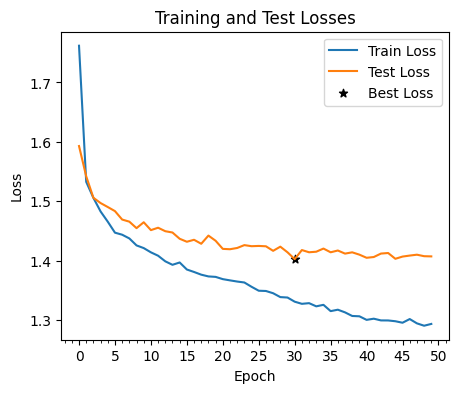

In [13]:
fst.loss_curve(train_losses, test_losses, best_epoch, best_loss, max_step=5, min_step=1, 
               fig_size=(5, 4), format='svg', save_path=f'{demo_data}{fig_path}NPC_loss_curve.svg')

<div class="alert alert-info">

**Note**
The above cell for `section 2.1` needs to be run more than once by setting different parameters in the given `.json` file, if the correlation in `section 3.4` is not satisfying. If one obtains a good performance, one can save the `dir_name` and then directly use it to load the trained model and infer gene expression, and doesn't need to run `section 2.1` again. Recommended parameter fine-tuning and its range: `training_epoch`: 40~60; 
`temperature`: 0.01-0.05.

</div>

## 3. Inference, Imputation and Evaluation on "within spot"

3.1 Infer the gene expression of within spots

You can use the `dir_name` obtained from section 2.1, here we use our trained `logging/20250621001835815284` at [Goole Drive](https://drive.google.com/drive/folders/1Z6MqL3uouhlgmhV5Ouz_d58Di-ExK5Bt?usp=sharing) for paper results repeated.

In [14]:
!pwd

/ssd/users/lingyu/Python/FineSTtest09/FineST


In [15]:
## Load the trained model
model = fst.load_model(dir_name, parameter_file_path, gene_hv)

## Load test data
test_loader = fst.build_loaders_inference(batch_size=adata.shape[0], 
                                          image_embed_path=image_embed_path, 
                                          spatial_pos_path=spatial_pos_path, 
                                          reduced_mtx_path=reduced_mtx_path,
                                          image_clacss='HIPT',
                                          dataset_class='Visium16')
## Inference
(matrix_profile,
 reconstructed_matrix, 
 recon_ref_adata_image_f2, 
 reconstructed_matrix_reshaped, 
 input_coord_all) = fst.infer_model_fst(model, test_loader, logger, dataset_class='Visium16')

CUDA is available. GPU: NVIDIA GeForce RTX 3090


[2025-09-25 13:43:20] INFO - Running inference task...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:0
***** Begin perform_inference: ******


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]
[2025-09-25 13:43:21] INFO - Running inference task DONE!


***** batch_size=adata.shape[0] doen't effect *****
torch.Size([1331, 596])
torch.Size([1331, 16, 384])
1
1
1
***** *****
Finished extractting test data
Inference within spots: 0.4511 seconds
Reconstructed_matrix_reshaped shape:  torch.Size([21296, 596])


3.2 Get coordinates of sub-spots from within spots

We use `reshape_latent_image()` function to convert the super-resolved gene expression with 16X or 64X relolution `reconstructed_matrix_reshaped` (torch.Size([21296, 596]) or torch.Size([85184, 596])) into tensor format `reconstructed_matrix_reshaped_tensor` (torch.Size([1331, 16, 596]) or torch.Size([1331, 64, 596])).

In [16]:
## Get the sub-spot level gene expression of all genes on all within-spots
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='Visium16')
(_, _, all_spot_all_variable,
 C2, adata_infer) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                adata, gene_hv, patch_size=64, dataset_class='Visium16')
print(adata_infer)

_, adata_infer_reshape = fst.reshape_latent_image(torch.tensor(adata_infer.X), dataset_class='Visium16')
adata_infer_spot = fst.reshape2adata(adata, adata_infer_reshape, gene_hv)
print(adata_infer_spot)

## save adata
adata_infer.write_h5ad(f'{demo_data}{save_data}adata_infer.h5ad')    # adata 21296 × 596
adata_infer_spot.write_h5ad(f'{demo_data}{save_data}adata_infer_spot.h5ad')    # adata 1331 × 596

pixel_step (half of patch_size): 8.0
AnnData object with n_obs × n_vars = 21296 × 596
    obs: 'x', 'y'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


<div class="alert alert-info">

**Note**
Here, `adata_infer` is the inferred super-resolved gene expression data with 16X or 64X solution.
</div>

pixel_step (half of patch_size): 8.0
first_spot_first_variable shape: (16,)


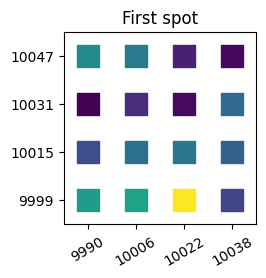

In [17]:
## Plot the first_spot_first_variable spiltting
(first_spot_first_variable, C,
 _, _, _) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor, adata, gene_hv, 
                                         p=0, q=0, patch_size=64, dataset_class='Visium16')
print("first_spot_first_variable shape:", first_spot_first_variable.shape)

fstplt.subspot_expr(C, first_spot_first_variable, patch_size=64, dataset_class='Visium16', 
                     marker='s', s=250, rotation=30, fig_size=(2.5, 2.5), format='svg', 
                    save_path=f'{demo_data}{fig_path}spot_splitting.svg')

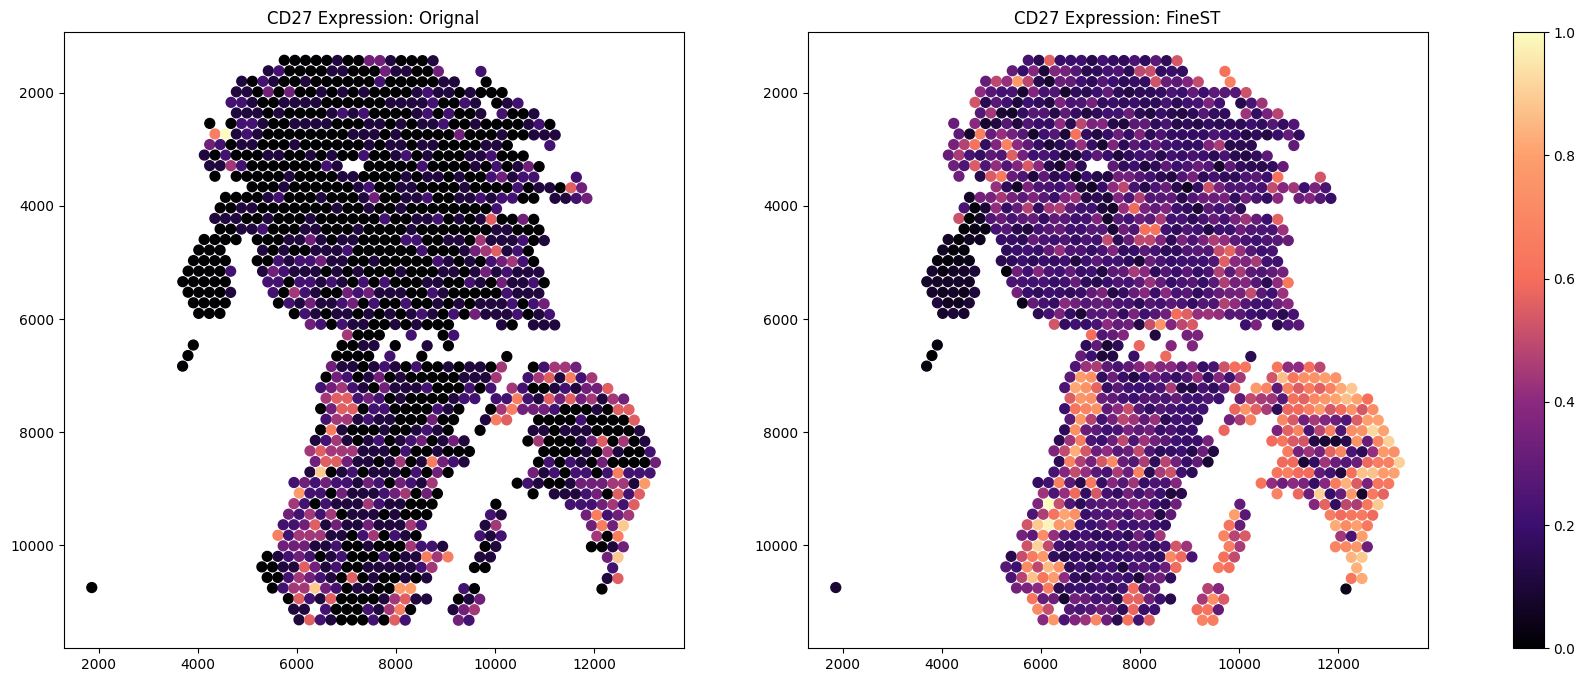

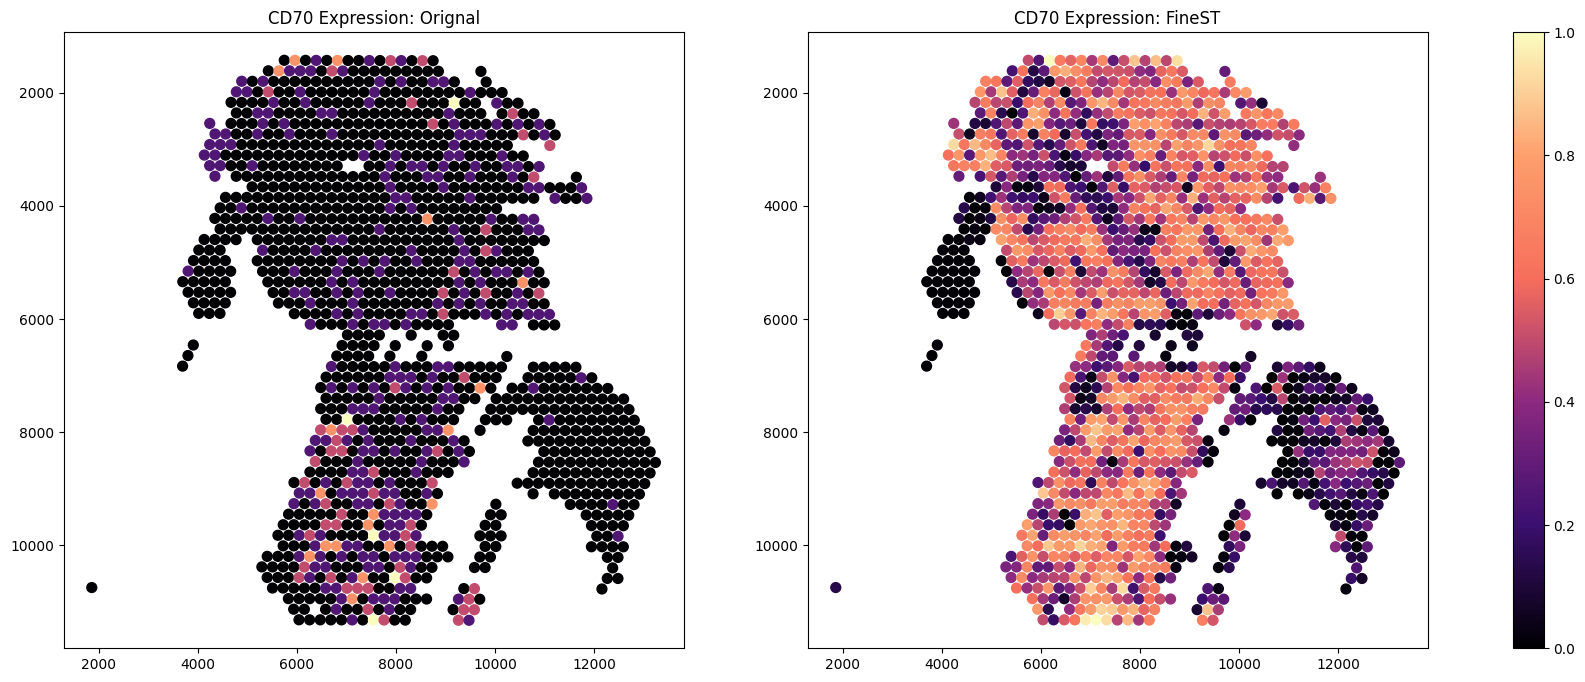

In [18]:
## Show marker gene expression -- only infer from image
fstplt.gene_expr_compare(adata, "CD27", adata_infer_reshape, gene_hv, s=50, save_path=None)
fstplt.gene_expr_compare(adata, "CD70", adata_infer_reshape, gene_hv, s=50, save_path=None)

# fstplt.gene_expr(adata, adata_infer_reshape, gene_selet='CD70', marker='o', 
#                  s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD70_expr_infer_spot_within.pdf')
# fstplt.gene_expr(adata, adata_infer_reshape, gene_selet='CD27', marker='o', 
#                  s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD27_expr_infer_spot_within.pdf')

[2025-09-25 13:43:41] INFO - mean correlation of spots: 0.8992568746630538
[2025-09-25 13:43:41] INFO - mean correlation of genes: 0.1682490569089236


mean correlation of spots:  0.8992568746630538
mean correlation of genes:  0.1682490569089236


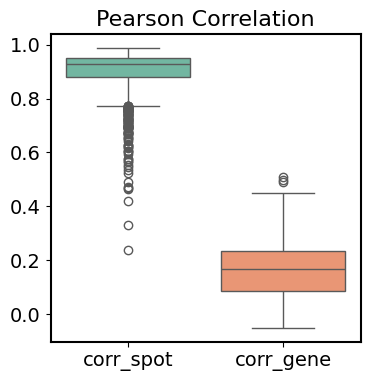

[2025-09-25 13:43:42] INFO - mean correlation of spots: 0.7000346476979751
[2025-09-25 13:43:42] INFO - mean correlation of genes: 0.12485059207355811


mean correlation of spots:  0.7000346476979751
mean correlation of genes:  0.12485059207355811


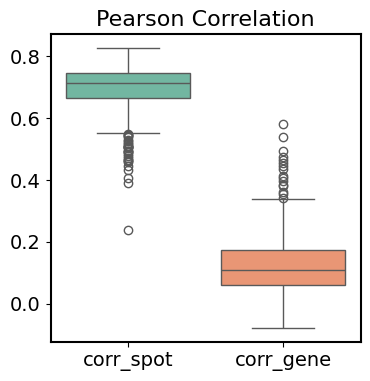

In [19]:
## save the correlation -- -- only infer from image
fstplt.mean_cor_box(adata, adata_infer_reshape, logger, save_path=f'{demo_data}{fig_path}Boxplot_infer_cor_count.pdf')
fstplt.mean_cor_box(adata_norml, adata_infer_reshape, logger, save_path=f'{demo_data}{fig_path}Boxplot_infer_cor_norml.pdf')

Pearson correlations:  0.1682490569089236


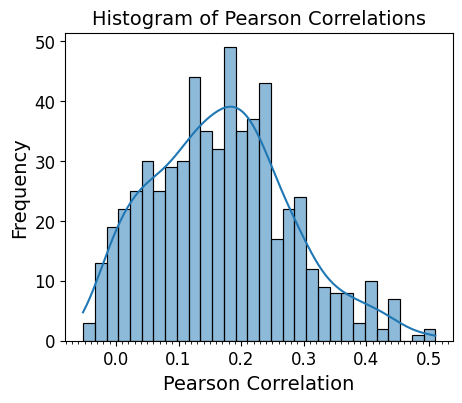

In [20]:
## Pearson correlations
fstplt.cor_hist(adata, adata_infer_spot.to_df(), 
                 fig_size=(5, 4), trans=False, format='svg', 
                 save_path=f'{demo_data}{fig_path}Hist_infer_cor_count.svg')

3.3 Impute the gene expression of sub-spots

Input: two input files: \
    - `adata`: original spot-level gene expression data (within spots). \
    - `adata_infer`: inferred super-resolved gene expression data (within spots). 

Input: three input files: \
    - `adata_impt`: `= w*adata_infer + (1-w)*sudo_adata`, predicted super-resolved gene expression data (here `w=0.5`).\
    - `sudo_adata`: Imputed data using the nearest `k` neighbors of within spots (here `k=6`). \
    - ` data_impt`: predicted super-resolved gene expression data in tensor form (within spots).

In [21]:
adata_smooth = fst.impute_adata(adata, adata_infer, C2, gene_hv, 
                                dataset_class='Visium16', weight_exponent=2)
adata_imput, data_impt = fst.weight_adata(adata_infer, adata_smooth, gene_hv, w=0.5)
print(adata_imput)

_, data_impt_reshape = fst.reshape_latent_image(data_impt, dataset_class='Visium16')
adata_imput_spot = fst.reshape2adata(adata, data_impt_reshape, gene_hv)
print(adata_imput_spot)

## save adata
adata_imput.write_h5ad(f'{demo_data}{save_data}_adata_imput.h5ad')    # adata: 21296 × 596
adata_imput_spot.write_h5ad(f'{demo_data}{save_data}adata_imput_spot.h5ad')    # adata: 1331 × 596

Smoothing time: 4.7656 seconds
AnnData object with n_obs × n_vars = 21296 × 596
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 1331 × 596
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


<div class="alert alert-info">

**Note**
For performance evaluation, we integrate super-resolved gene expression `data_impt` into spot-level gene expression `data_impt_reshape` (i.e., from 16x sub-spot level to spot level)
</div>

3.4 Visualization: selected gene (Original vs. FineST)

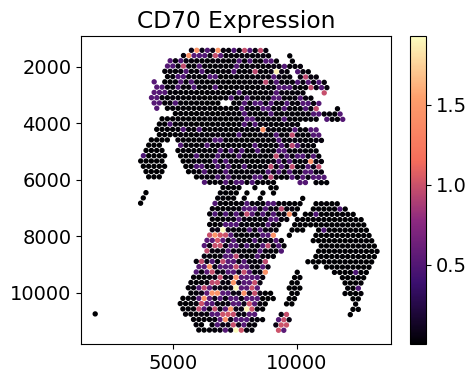

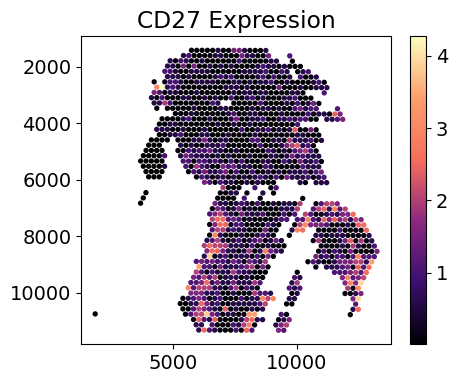

In [22]:
# fstplt.gene_expr_compare(adata, "CD70", data_impt_reshape, gene_hv, s=50, save_path=None)
# fstplt.gene_expr_compare(adata, "CD27", data_impt_reshape, gene_hv, s=50, save_path=None)

fstplt.gene_expr(adata, data_impt_reshape, gene_selet='CD70', marker='o', 
                 s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD70_expr_imput_spot_within.pdf')
fstplt.gene_expr(adata, data_impt_reshape, gene_selet='CD27', marker='o', 
                 s=8, figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD27_expr_imput_spot_within.pdf')

3.4 Correlation: Selected gene、all spots and all genes、mean correlation box

The correlation can be used as a measure to evaluate the gene expression prediction performance. Here we provide three functions: \
    - `sele_gene_cor`: show the selected gene correlation (Reconstructed by FineST vs. Original). \
    - `mean_cor`     : calculate the mean correlation of all spots or all genes. \
    - `mean_cor_box` : box plot of correlation for all spots or all genes.

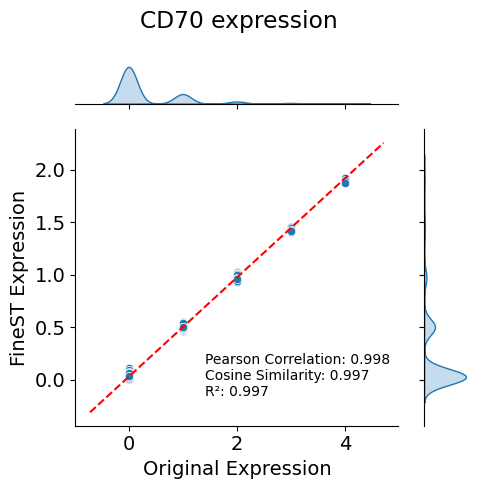

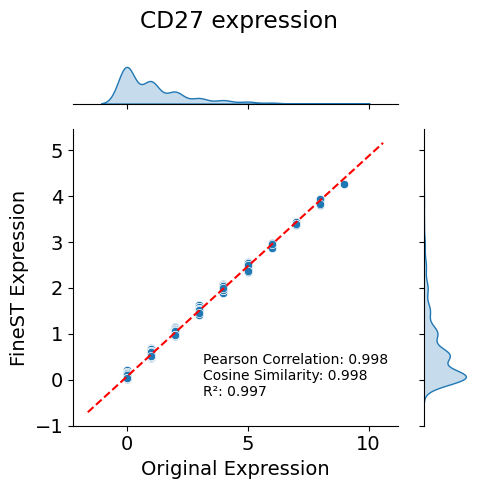

In [23]:
fstplt.sele_gene_cor(adata, data_impt_reshape, gene_hv, gene = "CD70", 
                     ylabel='FineST Expression', title = "CD70 expression", size=5, 
                     save_path=f'{demo_data}{fig_path}CD70_cor_imput_spot_within.pdf') 
fstplt.sele_gene_cor(adata, data_impt_reshape, gene_hv, gene = "CD27", 
                     ylabel='FineST Expression', title = "CD27 expression", size=5, 
                     save_path=f'{demo_data}{fig_path}CD27_cor_imput_spot_within.pdf') 

In [24]:
logger.info("Running Gene Correlation task...")
(pearson_cor_gene, 
 spearman_cor_gene, 
 cosine_sim_gene) = fst.mean_cor(adata, data_impt_reshape, 'reconf2', sample="gene")
logger.info("Running Gene Correlation task DINE!")

[2025-09-25 13:44:02] INFO - Running Gene Correlation task...


matrix1:  (1331, 596)
matrix2:  (1331, 596)
Mean Pearson correlation coefficient--reconf2: 0.9986


[2025-09-25 13:44:03] INFO - Running Gene Correlation task DINE!


Mean Spearman correlation coefficient--reconf2: 0.5622
Mean cosine similarity--reconf2: 0.9963


[2025-09-25 13:44:03] INFO - mean correlation of spots: 0.9949710085708371
[2025-09-25 13:44:04] INFO - mean correlation of genes: 0.9985878561071674


mean correlation of spots:  0.9949710085708371
mean correlation of genes:  0.9985878561071674


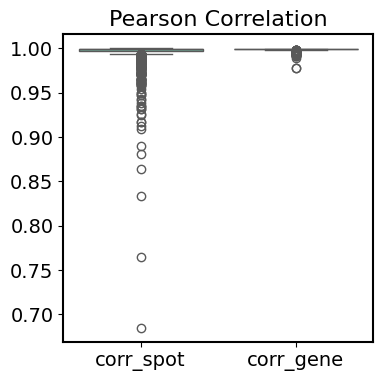

In [25]:
fstplt.mean_cor_box(adata, data_impt_reshape, logger, save_path=f'{demo_data}{fig_path}Boxplot_imput_cor_count.pdf')

<div class="alert alert-info">

**Note**
Here the `adata_impt` is the imputed spot-level gene expression from FineST, it only contains the given 1331 within spots. The comparisons are based on the original adata `patient1_adata_orignal.h5ad` vs. FineST's predicted adata `patient1_adata.h5ad`.

</div>

## 4. Infer gene expression of "within spot" and "between spot" 

**Spot_interpolate**
```Python
cd ~/FineST_demo
conda activate FineST
python ./demo/Spot_interpolation.py \
   --position_path FineST_tutorial_data/spatial/tissue_positions_list.csv 
```

**Step0: HE image feature extraction**
```Python
python ./demo/Image_feature_extraction.py \
   --dataset NEW_NPC \
   --position_path FineST_tutorial_data/spatial/tissue_positions_list_add.csv  \
   --rawimage_path FineST_tutorial_data/20210809-C-AH4199551.tif \
   --scale_image False \
   --method HIPT \
   --patch_size 64 \
   --output_img FineST_tutorial_data/ImgEmbeddings/NEW_pth_64_16_image \
   --output_pth FineST_tutorial_data/ImgEmbeddings/NEW_pth_64_16 \
   --logging FineST_tutorial_data/ImgEmbeddings/
```

In [26]:
!python ./demo/Spot_interpolation.py \
    --position_path FineST_tutorial_data/spatial/tissue_positions_list.csv 

Interpolation time: 2.48 seconds
# of interpolated between-spots: 2.786 times vs. original within-spots
# of final all spots: 3.786 times vs. original within-spots


In [27]:
!python ./demo/Image_feature_extraction.py \
   --dataset NEW_NPC \
   --position_path FineST_tutorial_data/spatial/tissue_positions_list_add.csv  \
   --rawimage_path FineST_tutorial_data/20210809-C-AH4199551.tif \
   --scale_image False \
   --method HIPT \
   --patch_size 64 \
   --output_img FineST_tutorial_data/ImgEmbeddings/NEW_pth_64_16_image \
   --output_pth FineST_tutorial_data/ImgEmbeddings/NEW_pth_64_16 \
   --logging FineST_tutorial_data/ImgEmbeddings/

      Unnamed: 0  array_row  array_col  pxl_row_in_fullres  pxl_col_in_fullres
0              0       20.5       17.5              5247.5              3751.0
1              1       21.5       17.5              5434.0              3750.5
2              2       25.5       17.5              6180.5              3748.5
3              3       28.5       17.5              6740.5              3747.0
4              4       21.0       18.0              5340.5              3804.5
...          ...        ...        ...                 ...                 ...
3703        3703       38.5      104.5              8631.0             13074.5
3704        3704       39.5      104.5              8817.5             13074.0
3705        3705       38.0      105.0              8537.5             13128.5
3706        3706       37.5      105.5              8444.5             13182.5
3707        3707       38.5      105.5              8631.0             13182.0

[3708 rows x 5 columns]
[2025-09-25 13:44:22] INFO 

4.1 Get all spot coordinates (within spot & between spot) of image embeddings

Input: two input file pathways: \
    - `file_paths_spot`: image embedding, of within spots, from **Setp0** `Image_feature_extraction.py`. \
    - `file_paths_between_spot`: image embedding, of between spots,  from **Setp0** `Image_feature_extraction.py`. 

In [28]:
## Add coords for each .pth file
file_paths_spot = os.listdir(f'{demo_data}ImgEmbeddings/pth_64_16/')
file_paths_between_spot = os.listdir(f'{demo_data}ImgEmbeddings/NEW_pth_64_16/')
file_paths_all = file_paths_spot + file_paths_between_spot
print("file_paths_spot number: ", len(file_paths_spot))
print("file_paths_between_spot number:", len(file_paths_between_spot))
print("file_paths_all number:", len(file_paths_all))

## Merge, sort and process file paths
data_all = fst.get_image_coord_all(file_paths_all)
position_order_allspot = pd.DataFrame(data_all, columns=['pixel_y', 'pixel_x'])

## save all spots
position_order_allspot.to_csv(f'{demo_data}{link_data}position_order_all.csv', index=False, header=False)

file_paths_spot number:  1331
file_paths_between_spot number: 3708
file_paths_all number: 5039


<div class="alert alert-info">

**Note**
The above two cells for `section 4.1` only need to be run once, aiming to generate the ordered ST spot coordinates `position_order_all.csv` according to image pixel coordinates.

</div>

4.2 Load all spot image embeddings with their coordinates

In [29]:
import glob
file_paths_spot = f'{demo_data}ImgEmbeddings/pth_64_16/*.pth'
file_paths_between_spot = f'{demo_data}ImgEmbeddings/NEW_pth_64_16/*.pth'
spatial_pos_path=f'{demo_data}{link_data}position_order_all.csv'

4.4 Load the trained model to infer all spots

In [30]:
## Load the trained model
model = fst.load_model(dir_name, parameter_file_path, gene_hv)

## load all spot (within and between) spots data
all_dataset = fst.build_loaders_inference_allimage(batch_size=len(file_paths_all), 
                                                   file_paths_spot=file_paths_spot, 
                                                   file_paths_between_spot=file_paths_between_spot, 
                                                   spatial_pos_path=spatial_pos_path, 
                                                   dataset_class='Visium16')
## inference
logger.info("Running inference tesk between spot...")
start_time = time.time()
(recon_ref_adata_image_f2, 
reconstructed_matrix_reshaped,
representation_image_reshape_between_spot,
input_image_exp_between_spot,
input_coord_all) = fst.perform_inference_image_between_spot(model, all_dataset, dataset_class='Visium16')
print("--- %s seconds ---" % (time.time() - start_time))

## print
print("recon_ref_adata_image_f2:", recon_ref_adata_image_f2.shape)
logger.info("Running inference tesk between spot DONE!")

CUDA is available. GPU: NVIDIA GeForce RTX 3090
***** Building loaders_inference between spot *****


[2025-09-25 13:44:55] INFO - Running inference tesk between spot...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:0
***** Begin perform_inference: ******


100%|██████████| 1/1 [00:00<00:00, 10.97it/s]
[2025-09-25 13:44:55] INFO - Running inference tesk between spot DONE!


***** batch_size=adata.shape[0] *****
torch.Size([5039, 16, 384])
1
Finished extractting image_between_spot data
--- 0.10917234420776367 seconds ---
recon_ref_adata_image_f2: (5039, 596)


4.5 Visualization all spots

In [31]:
## process_and_check_duplicates of the coordinates of all spots (within and between)
spatial_loc_all = fst.get_allspot_coors(input_coord_all)
print(spatial_loc_all)

Are there any duplicate rows? : False
[[10014.5  9836. ]
 [10015.5  9462.5]
 [10020.5  7596.5]
 ...
 [ 9924.   3117. ]
 [ 9925.   2743. ]
 [ 9927.   1997. ]]


CD70 gene expression dim: (5039, 1)
CD70 gene expression: 
 [[0.01830675]
 [0.02473335]
 [0.03261732]
 ...
 [0.04491646]
 [0.05265491]
 [0.05270657]]


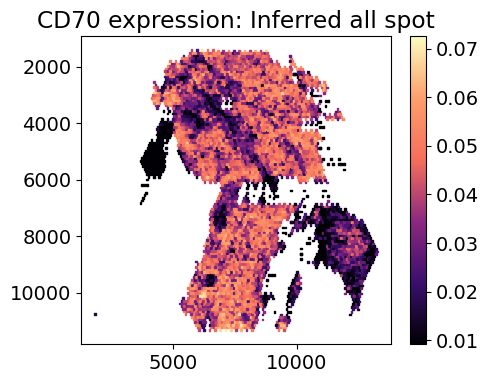

CD27 gene expression dim: (5039, 1)
CD27 gene expression: 
 [[0.12539947]
 [0.09575612]
 [0.13099366]
 ...
 [0.04503243]
 [0.05374994]
 [0.06823436]]


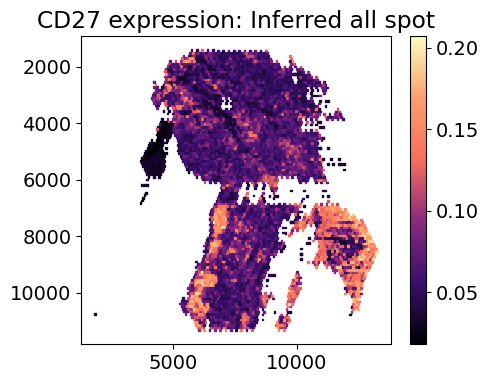

In [32]:
fstplt.gene_expr_allspots("CD70", spatial_loc_all, recon_ref_adata_image_f2, 
                          gene_hv, 'Inferred all spot', s=1.5, marker='s',
                          figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD70_expr_infer_allspot.pdf')
fstplt.gene_expr_allspots("CD27", spatial_loc_all, recon_ref_adata_image_f2, 
                          gene_hv, 'Inferred all spot', s=1.5, marker='s',
                          figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD27_expr_infer_allspot.pdf')

4.6 Visualization all sub-spots

In [33]:
## Get the sub-spot level gene expression of all genes in all spots
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='Visium16')
print("reconstructed_matrix_reshaped_tensor size: ", reconstructed_matrix_reshaped_tensor.shape)

(_, _, all_spot_all_variable, 
 C2, adata_infer_all) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                    spatial_loc_all, gene_hv, patch_size=64, dataset_class="Visium16")
print(adata_infer_all)

reconstructed_matrix_reshaped_tensor size:  torch.Size([5039, 16, 596])
pixel_step (half of patch_size): 8.0
AnnData object with n_obs × n_vars = 80624 × 596
    obs: 'x', 'y'
    obsm: 'spatial'


In [32]:
# fstplt.gene_expr_allspots("CD70", C2, all_spot_all_variable, gene_hv, 
#                            'Inferred all spot', marker='s', s=0.3, 
#                           figsize=(15, 12), save_path=f'{demo_data}{fig_path}CD70_expr_infer_allsubspot.pdf')
# fstplt.gene_expr_allspots("CD27", C2, all_spot_all_variable, gene_hv, 
#                            'Inferred all spot', marker='s', s=0.3, 
#                           figsize=(15, 12), save_path=f'{demo_data}{fig_path}CD27_expr_infer_allsubspot.pdf')

## 5. Imputate sub-spot gene expression using measured spot expression

5.1 Impute the gene expression of all sub-spots from all spots (within spots and between spots)

In [34]:
adata_smooth_all = fst.impute_adata(adata, adata_infer_all, C2, gene_hv, dataset_class='Visium16', weight_exponent=2)
print(adata_smooth_all)
adata_impt_all, data_impt_all = fst.weight_adata(adata_infer_all, adata_smooth_all, gene_hv, w=0.5)  
print(adata_impt_all)

## save adata 
adata_impt_all.write_h5ad(f'{demo_data}{save_data}adata_imput_all_subspot.h5ad')    # aadata: 322496 × 596

Smoothing time: 18.9161 seconds
AnnData object with n_obs × n_vars = 80624 × 596
    obs: 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 80624 × 596
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


<div class="alert alert-info">

**Note**
Here, `adata_impt_all` is the imputed sub-spot-level gene expression from FineST. `patient1_adata_all.h5ad` contains about 1331x4x16 sub-spots. (1331 within spots, 1331x3 between spots, 16x resolution).

</div>

5.2 Convert super-resolved gene expression to spot-level and save the imputated spot-level adata

In [35]:
_, adata_impt_all_reshape = fst.reshape_latent_image(data_impt_all, dataset_class='Visium16')
adata_impt_spot = fst.reshape2adata(adata, adata_impt_all_reshape, gene_hv, spatial_loc_all)

## save adata
adata_impt_spot.write_h5ad(f'{demo_data}{save_data}adata_imput_all_spot.h5ad')    # adata: 5039 × 596

<div class="alert alert-info">

**Note**
Here, `adata_impt_spot` is the imputed sub-spot-level gene expression from FineST. `patient1_adata_all_spot.h5ad` contains about 1331x4 spots. (1331 within spots, 1331x3 between spots), it is integrated from `patient1_adata_all.h5ad` using the `reshape_latent_image` function.

</div>

5.3 Visualization: gene at all spot

CD70 gene expression dim: (5039, 1)
CD70 gene expression: 
 [[0.00915338]
 [0.01236668]
 [0.01630866]
 ...
 [0.02884209]
 [0.03915556]
 [0.032858  ]]


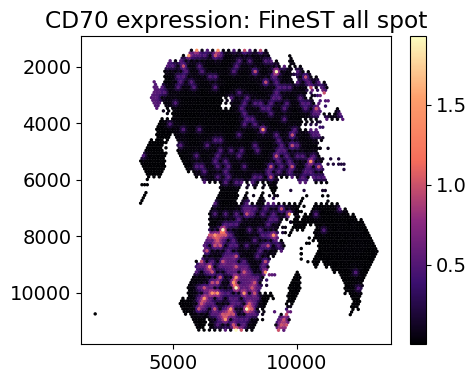

CD27 gene expression dim: (5039, 1)
CD27 gene expression: 
 [[0.87453638]
 [0.84026835]
 [1.33540993]
 ...
 [0.97775391]
 [0.04598134]
 [0.03842698]]


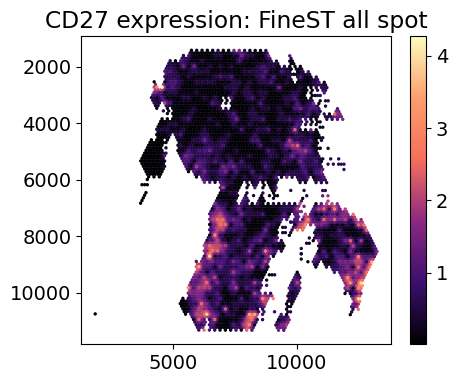

In [36]:
fstplt.gene_expr_allspots("CD70", spatial_loc_all, adata_impt_all_reshape, gene_hv, 
                          'FineST all spot', marker='h', s=2.5, 
                           figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD70_expr_imput_allspot.pdf')
fstplt.gene_expr_allspots("CD27", spatial_loc_all, adata_impt_all_reshape, gene_hv, 
                          'FineST all spot', marker='h', s=2.5, 
                           figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD27_expr_imput_allspot.pdf')

5.4 Visualization: gene at all sub-spot

In [36]:
# fstplt.gene_expr_allspots("CD70", C2, adata_impt_all.X, gene_hv, 
#                           'FineST all sub-spot', marker='s', s=0.3, figsize=(15, 12), 
#                           save_path=f'{demo_data}{fig_path}CD70_expr_imput_allsubspot.pdf')
# fstplt.gene_expr_allspots("CD27", C2, adata_impt_all.X, gene_hv, 
#                           'FineST all sub-spot', marker='s', s=0.3, figsize=(15, 12), 
#                           save_path=f'{demo_data}{fig_path}CD27_expr_imput_allsubspot.pdf')

## 6. Infer and impute gene expression at "single-cell" level

<div class="alert alert-info">

**Note**
Section 6 directly infers super-resolved gene expression based on image features from ``nuclei segmentation``. The image embeddings `sc_pth_16_16` is based on `adata_imput_all_spot.adata` from **Nuclei segmentation** . The results `NucleiSegments` can be downloaded [Goole Drive](https://drive.google.com/drive/folders/1YE2JILfbbj1HTPZDmVGxy07gr6R_7mTP?usp=drive_link).
</div>

**Nuclei segmentation**
```Python
conda activate FineST
python ./demo/StarDist_nuclei_segmente.py \
   --tissue NPC_allspot_p075 \
   --out_dir FineST_tutorial_data/NucleiSegments \
   --adata_path FineST_tutorial_data/SaveData/adata_imput_all_spot.h5ad \
   --img_path FineST_tutorial_data/20210809-C-AH4199551.tif \
   --prob_thresh 0.75
```

**Step0: HE image feature extraction**
```Python
python ./demo/Image_feature_extraction.py \
   --dataset sc_NPC \
   --position_path FineST_tutorial_data/NucleiSegments/NPC_allspot_p075/position_all_tissue_sc.csv  \
   --rawimage_path FineST_tutorial_data/20210809-C-AH4199551.tif \
   --scale_image False \
   --method HIPT \
   --patch_size 16 \
   --output_img FineST_tutorial_data/ImgEmbeddings/sc_pth_16_16_image \
   --output_pth FineST_tutorial_data/ImgEmbeddings/sc_pth_16_16 \
   --logging FineST_tutorial_data/ImgEmbeddings/
```

In [ ]:
!python ./demo/StarDist_nuclei_segmente.py \
    --tissue NPC_allspot_p075 \
    --out_dir FineST_tutorial_data/NucleiSegments \
    --adata_path FineST_tutorial_data/SaveData/adata_imput_all_spot.h5ad \
    --img_path FineST_tutorial_data/20210809-C-AH4199551.tif \
    --prob_thresh 0.75

In [39]:
# (FineST09) lingyu@woody:~/ssd/Python/FineSTtest09/FineST$ python ./demo/StarDist_nuclei_segmente.py \
#     --tissue NPC_allspot_p075 \
#     --out_dir FineST_tutorial_data/NucleiSegments \
#     --adata_path FineST_tutorial_data/SaveData/adata_imput_all_spot.h5ad \
#     --img_path FineST_tutorial_data/20210809-C-AH4199551.tif \
#     --prob_thresh 0.75
# 2025-09-25 13:50:52.273789: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
# 2025-09-25 13:50:52.999219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
# To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
# 2025-09-25 13:50:54.081553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
# 2025-09-25 13:50:56,221 : INFO : Reading spatial data: 
# FineST_tutorial_data/SaveData/adata_imput_all_spot.h5ad
# 2025-09-25 13:50:56,302 : INFO : Spatial data shape: (5039, 596)
# 2025-09-25 13:50:56,303 : INFO : Spatial data shape after QC: (5039, 596)
# 2025-09-25 13:50:56,303 : INFO : Reading image data: FineST_tutorial_data/SaveData/adata_imput_all_spot.h5ad
# utils.py (494): The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
# 2025-09-25 13:50:59,203 : INFO : Image shape: (17351, 17319)
# Found model '2D_versatile_he' for 'StarDist2D'.
# 2025-09-25 13:50:59.684219: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
# Skipping registering GPU devices...
# Loading network weights from 'weights_best.h5'.
# Loading thresholds from 'thresholds.json'.
# Using default values: prob_thresh=0.692478, nms_thresh=0.3.
# Found model '2D_versatile_he' for 'StarDist2D'.
# Loading network weights from 'weights_best.h5'.
# Loading thresholds from 'thresholds.json'.
# Using default values: prob_thresh=0.692478, nms_thresh=0.3.
# 2025-09-25 13:51:22.272535: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38504202240 exceeds 10% of free system memory.
# 2025-09-25 13:51:24.203984: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 38504202240 exceeds 10% of free system memory.
# 2025-09-25 13:51:31.873701: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9626050560 exceeds 10% of free system memory.
# 2025-09-25 13:51:51.071940: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9626050560 exceeds 10% of free system memory.
# 2025-09-25 13:51:52.818065: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9626050560 exceeds 10% of free system memory.
# 2025-09-25 13:52:53,909 : INFO : Number of segments: 23984
#   0%|                                                                                                                                                              | 0/5039 [00:00<?, ?/s]utils.py (494): The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
#   0%|                                                                                                                                                      | 1/5039 [00:00<18:33,  4.52/s]_feature_mixin.py (354): invalid value encountered in true_divide
# _feature_mixin.py (355): invalid value encountered in true_divide
# 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5039/5039 [00:27<00:00, 182.91/s]
# 2025-09-25 13:54:27,894 : INFO : image_features: 
#       segmentation_label                              segmentation_centroid
# 0                      3  [[ 9977.0775667   9767.        ]\n [10084.    ...
# 1                      5  [[10085.          9455.57811205]\n [ 9976.1274...
# 2                      3  [[ 9951.          7527.        ]\n [10090.    ...
# 3                      1                                        [[nan nan]]
# 4                      7  [[ 9964.15870219  5800.        ]\n [ 9985.0599...
# ...                  ...                                                ...
# 5034                  14  [[9946.54089184 4306.52015055]\n [9880.4868521...
# 5035                   7  [[9914.79312114 3557.1265842 ]\n [9935.5640816...
# 5036                  11  [[9922.17575074 3164.91015525]\n [9886.6376639...
# 5037                   6  [[9880.04078092 2770.32105892]\n [9944.9577211...
# 5038                   0                                                 []

# [5039 rows x 2 columns]
# 2025-09-25 13:54:27,905 : INFO : coord_cell_filtered: 
#        pxl_row_in_fullres  pxl_col_in_fullres spot_index cell_index  cell_nums
# 0             9977.077567         9767.000000          0        0_0          3
# 1            10084.000000         9906.000000          0        0_1          3
# 2             9945.000000         9876.009111          0        0_2          3
# 3            10085.000000         9455.578112          1        1_0          5
# 4             9976.127421         9406.193078          1        1_1          5
# ...                   ...                 ...        ...        ...        ...
# 40599         9944.957721         2781.380571       5037     5037_1          6
# 40600         9856.000000         2674.000000       5037     5037_2          6
# 40601         9938.508909         2677.594658       5037     5037_3          6
# 40602         9995.000000         2746.618412       5037     5037_4          6
# 40603         9932.710738         2813.000000       5037     5037_5          6

# [40269 rows x 5 columns]

In [38]:
!python ./demo/Image_feature_extraction.py \
   --dataset sc_NPC \
   --position_path FineST_tutorial_data/NucleiSegments/NPC_allspot_p075/position_all_tissue_sc.csv  \
   --rawimage_path FineST_tutorial_data/20210809-C-AH4199551.tif \
   --scale_image False \
   --method HIPT \
   --patch_size 16 \
   --output_img FineST_tutorial_data/ImgEmbeddings/sc_pth_16_16_image \
   --output_pth FineST_tutorial_data/ImgEmbeddings/sc_pth_16_16 \
   --logging FineST_tutorial_data/ImgEmbeddings/

       Unnamed: 0  pxl_row_in_fullres  ...  cell_index  cell_nums
0               0         9977.077567  ...         0_0          3
1               1        10084.000000  ...         0_1          3
2               2         9945.000000  ...         0_2          3
3               3        10085.000000  ...         1_0          5
4               4         9976.127421  ...         1_1          5
...           ...                 ...  ...         ...        ...
40264       40599         9944.957721  ...      5037_1          6
40265       40600         9856.000000  ...      5037_2          6
40266       40601         9938.508909  ...      5037_3          6
40267       40602         9995.000000  ...      5037_4          6
40268       40603         9932.710738  ...      5037_5          6

[40269 rows x 6 columns]
[2025-09-25 13:54:39] INFO - tissue_position: 
             pxl_row_in_fullres  pxl_col_in_fullres  ...  cell_index cell_nums
Unnamed: 0                                          ... 

6.1 Infer the gene expression of at single-cell resolution

You can use the `dir_name` just obtained from Section 2 (Model training), but just like Section 3, here we use our trained `logging/20250621001835815284` for paper results repeated.

In [40]:
file_paths_sc = sorted(os.listdir(f'{demo_data}/ImgEmbeddings/sc_pth_16_16/'))
print("Image embedding file: ", file_paths_sc[:2])

## Image patch position
data_all_sc = fst.get_image_coord_all(file_paths_sc)
spatial_loc_sc = pd.DataFrame(data_all_sc, columns=['pixel_y', 'pixel_x'])

## save .csv file
spatial_loc_sc.to_csv(f'{demo_data}{link_data}/position_order_sc.csv', index=False, header=False)

Image embedding file:  ['sc_NPC_10000.0_9328.81908402034.pth', 'sc_NPC_10000.0_9579.185992854487.pth']


<div class="alert alert-info">

**Note**
The above two cells for `section 6.1` only need to be run once, aiming to generate the ordered ST spot coordinates `position_order_sc.csv` according to image pixel coordinates.

</div>

In [41]:
import glob
image_embed_path_sc = f'{demo_data}/ImgEmbeddings/sc_pth_16_16/*.pth'
spatial_pos_path_sc = f'{demo_data}{link_data}/position_order_sc.csv'

In [42]:
## load models
model = fst.load_model(dir_name, parameter_file_path, gene_hv)   
model.to(device)

## load all data
all_dataset_sc = fst.build_loaders_inference_allimage(batch_size=len(file_paths_sc),
                                                       file_paths_spot=image_embed_path_sc, 
                                                       spatial_pos_path=spatial_pos_path_sc, 
                                                       dataset_class='VisiumSC')

## inference
logger.info("Running inference tesk single-nuclei...")
start_time = time.time()
(recon_ref_adata_image_f2, 
reconstructed_matrix_reshaped,
representation_image_reshape_between_spot,
input_image_exp_between_spot,
input_coord_all) = fst.perform_inference_image_between_spot(model, all_dataset_sc, dataset_class='VisiumSC')
print("--- %s seconds ---" % (time.time() - start_time))

## print
print("recon_ref_adata_image_f2 shape:", recon_ref_adata_image_f2.shape)
logger.info("Running inference tesk single-nuclei DONE!")

CUDA is available. GPU: NVIDIA GeForce RTX 3090
***** Building loaders_inference sc image *****


[2025-09-25 13:58:23] INFO - Running inference tesk single-nuclei...


Finished loading all files
***** Finished building loaders_inference *****
device cuda:0
***** Begin perform_inference: ******


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]
[2025-09-25 13:58:24] INFO - Running inference tesk single-nuclei DONE!


***** batch_size=adata.shape[0] *****
torch.Size([40068, 1, 384])
1
Finished extractting image_between_spot data
--- 1.3687191009521484 seconds ---
recon_ref_adata_image_f2 shape: (40068, 596)


In [43]:
spatial_loc_sc = fst.get_allspot_coors(input_coord_all)
reconstructed_matrix_reshaped_tensor, _ = fst.reshape_latent_image(reconstructed_matrix_reshaped, 
                                                                   dataset_class='VisiumSC')
(_, _, all_spot_all_variable, 
 C2, adata_infer_sc) = fst.subspot_coord_expr_adata(reconstructed_matrix_reshaped_tensor,
                                                    spatial_loc_sc, gene_hv, patch_size=14, dataset_class="VisiumSC")
adata_smooth_sc = fst.impute_adata(adata, adata_infer_sc, C2, gene_hv, dataset_class='VisiumSC', weight_exponent=2)
adata_impt_sc, data_impt_sc = fst.weight_adata(adata_infer_sc, adata_smooth_sc, gene_hv, w=0.5)
print(adata_impt_sc)

## save adata
adata_impt_sc.write_h5ad(f'{demo_data}{save_data}adata_imput_all_sc.h5ad')    # adata: 40068 × 596

Are there any duplicate rows? : False
pixel_step (half of patch_size): 7.0
Smoothing time: 9.0351 seconds
AnnData object with n_obs × n_vars = 40068 × 596
    obs: 'x', 'y'
    uns: 'spatial'
    obsm: 'spatial'


In [42]:
## Save inferred expression
# fstplt.gene_expr_allspots("CD70", spatial_loc_sc, recon_ref_adata_image_f2, gene_hv, 
#                           'Inferred single-cell', s=0.6, 
#                          figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD70_expr_infer_allsc.pdf')
# fstplt.gene_expr_allspots("CD27", spatial_loc_sc, recon_ref_adata_image_f2, gene_hv, 
#                           'Inferred single-cell', s=0.6, 
#                           figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD27_expr_infer_allsc.pdf')

CD70 gene expression dim: (40068, 1)
CD70 gene expression: 
 [[0.00482715]
 [0.00481553]
 [0.00473698]
 ...
 [0.31381471]
 [0.00479249]
 [0.00481693]]


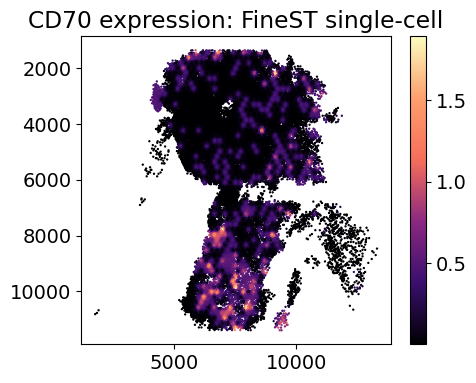

CD27 gene expression dim: (40068, 1)
CD27 gene expression: 
 [[0.20244662]
 [1.50185445]
 [0.87071394]
 ...
 [1.432219  ]
 [0.55735783]
 [0.61868262]]


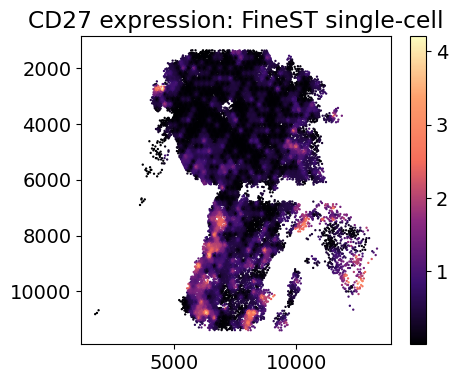

In [44]:
## Save imputed expression
_, adata_impt_sc_reshape = fst.reshape_latent_image(data_impt_sc, dataset_class='VisiumSC')

fstplt.gene_expr_allspots("CD70", spatial_loc_sc, adata_impt_sc_reshape, gene_hv, 
                          'FineST single-cell', s=0.6, 
                         figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD70_expr_imput_allsc.pdf')
fstplt.gene_expr_allspots("CD27", spatial_loc_sc, adata_impt_sc_reshape, gene_hv, 
                          'FineST single-cell', s=0.6, 
                         figsize=(5, 4), save_path=f'{demo_data}{fig_path}CD27_expr_imput_allsc.pdf')

<div class="alert alert-info">

**Note**
The above all .h5ad files `SaveData` can be downloaded from [Goole Drive](https://drive.google.com/drive/folders/1Ub6z8EBCfAIPIZ2VYCWzyu9tdt9m1XHY?usp=sharing).
</div>